# 作業

實作各種不一樣的方式來調整飽和 / 對比 / 明亮

1. 改變 color space 來調整飽和度
2. 實作直方圖均衡
3. alpha/ beta 調整對比 / 明亮

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_path = 'lena.png'

# 以彩色圖片的方式載入
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

## 改變飽和度

- 轉換成 HSV color space, 改變 s channel 的值

In [9]:
# 為了要改變飽和度，我們先把 color space 轉成 HSV 格式
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
change_percentage = 0.2

# 針對飽和度的值做改變，超過界線 0~1 的都會 bound
# 在 HSV color space 減少飽和度
img_hsv_down = img_hsv.astype('float32')
img_hsv_down[..., -2] = img_hsv_down[..., -2] / 255 - change_percentage
img_hsv_down[img_hsv_down[..., -2] < 0] = 0
img_hsv_down[..., -2] = img_hsv_down[..., -2] * 255
img_hsv_down = img_hsv_down.astype('uint8')

# 在 HSV color space 增加飽和度
img_hsv_up = img_hsv.astype('float32')
img_hsv_up[..., -2] = img_hsv_up[..., -2] / 255 + change_percentage
img_hsv_up[img_hsv_up[..., -2] > 1] = 1
img_hsv_up[..., -2] = img_hsv_up[..., -1] * 255
img_hsv_up = img_hsv_up.astype('uint8')

# 轉換 color space 回 BGR
img_hsv_down = cv2.cvtColor(img_hsv_down, cv2.COLOR_HSV2BGR)
img_hsv_up = cv2.cvtColor(img_hsv_up, cv2.COLOR_HSV2BGR)

# 組合圖片 + 顯示圖片
img_hsv_change = np.hstack((img, img_hsv_down, img_hsv_up))
while True:
    cv2.imshow('change saturation', img_hsv_change)

    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

## 直方圖均衡

1. case 1: 把彩圖拆開對每個 channel 個別做直方圖均衡再組合起來
2. case 2: 轉換 color space 到 HSV 之後對其中一個 channel 做直方圖均衡

In [3]:
(b, g, r) = cv2.split(img)
bH = cv2.equalizeHist(b)
gH = cv2.equalizeHist(g)
rH = cv2.equalizeHist(r)
frameH = cv2.merge((bH, gH, rH))
cv2.imshow('image', frameH)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
#不同方法
bH = cv2.equalizeHist(img[..., -3])
gH = cv2.equalizeHist(img[..., -2])
rH = cv2.equalizeHist(img[..., -1])
frameH = cv2.merge((bH, gH, rH))
cv2.imshow('image', frameH)
cv2.waitKey(0)
cv2.destroyAllWindows()

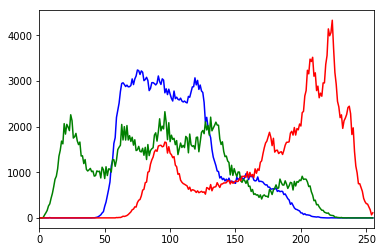

In [6]:
# case 1
#畫三通道影象的直方圖
def channel_hist(img):

    color = ('b', 'g', 'r')  #這裡畫筆顏色的值可以為大寫或小寫或只寫首字母或大小寫混合
    for i, color in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])  #計算直方圖
        plt.plot(hist, color)
        plt.xlim([0, 256])
    plt.show()


cv2.imshow('image', img)
channel_hist(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# case 2 - 轉換 color space 後只對其中一個 channel 做直方圖均衡
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_hsv_equal2 = cv2.equalizeHist(img_hsv[...,2])
img_hsv_equal = cv2.merge(( img_hsv[...,0], img_hsv[...,1],img_hsv_equal2))
img_hsv_equal = cv2.cvtColor(img_hsv_equal, cv2.COLOR_HSV2BGR)
# 組合圖片 + 顯示圖片
img_bgr_equalHist = np.hstack((img, frameH, img_hsv_equal))

while True:
    # 比較 (原圖, BGR color space 對每個 channel 做直方圖均衡, HSV color space 對明度做直方圖均衡)
    cv2.imshow('bgr equal histogram', img_bgr_equalHist)
    
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

In [19]:
import copy
#別人的做法
# case 1
img_bgr_equal = copy.copy(img)
#img_bgr_equal =img.copy()
# 每個 channel 個別做直方圖均衡
for i in range(3):
    equalHist_by_channel = cv2.equalizeHist(img[..., i])

    # 組合經過直方圖均衡的每個 channel
    img_bgr_equal[..., i] = equalHist_by_channel

# case 2 - 轉換 color space 後只對其中一個 channel 做直方圖均衡
img_hsv_equal = img_hsv.copy()
img_hsv_equal[..., 2] = cv2.equalizeHist(img_hsv[..., 2])
img_hsv_equal = cv2.cvtColor(img_hsv_equal, cv2.COLOR_HSV2BGR)

# 組合圖片 + 顯示圖片
img_bgr_equalHist = np.hstack((img, img_bgr_equal, img_hsv_equal))
while True:
    # 比較 (原圖, BGR color space 對每個 channel 做直方圖均衡, HSV color space 對明度做直方圖均衡)
    cv2.imshow('bgr equal histogram', img_bgr_equalHist)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

In [16]:
id(img)


80650288

## 調整對比 / 明亮

In [24]:
# alpha: 控制對比度 (1.0~3.0)
# beta: 控制明亮度 (0~255)
add_contrast = cv2.convertScaleAbs(img, alpha=2.0, beta=0)
add_lighness = cv2.convertScaleAbs(img, alpha=1.0, beta=133)

# 組合圖片 + 顯示圖片
img_contrast_light = np.hstack((img, add_contrast, add_lighness))
while True:
    # 比較不同程度的對比 / 明亮
    cv2.imshow('adjust contrast and brighness', img_contrast_light)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break